In [25]:
# imports
##
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from scipy.sparse import coo_matrix, hstack

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

import tqdm
from tqdm import trange

In [2]:
# Read in the data
##
tweets = pd.read_csv("csv files/ALL_DATA.csv")

In [3]:
# Preview data
##
tweets.head()

,tweet_id,text,created_at,likes,text length,polarity
0,1419307341560745985,face bound border two The covid said hidden,2021-07-25 17:43:34 EAT,0,43,-0.166667
1,1419307340680114179,I seeing looking like second global going,2021-07-25 17:43:34 EAT,0,41,0.000000
2,1419307335982346240,sentence people intensive care,2021-07-25 17:43:33 EAT,0,30,0.000000
3,1419307331599339521,contagious delta variant surging across nation...,2021-07-25 17:43:31 EAT,0,98,0.000000
4,1419307315220475908,sentence people intensive care,2021-07-25 17:43:28 EAT,0,30,0.000000


In [4]:
tweets.tail()

,tweet_id,text,created_at,likes,text length,polarity
135466,1242064075405905921,emergency response team sent trace catholic pr...,2020-03-23 12:22:06,4,73,0.113636
135467,1242064012797530112,time put mandatory hate happening,2020-03-23 12:21:51,1,33,-0.800000
135468,1242063970632163329,people lose trust governing becomes face choice,2020-03-23 12:21:41,1,47,0.000000
135469,1242063856727396352,incompetent wont die,2020-03-23 12:21:14,2,20,-0.350000
135470,1242063643883307008,next corona virus strain even deadly see lippi...,2020-03-23 12:20:23,1,58,-0.100000


# EDA
Exploring the data

In [5]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135471 entries, 0 to 135470
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   tweet_id     135471 non-null  int64  
 1   text         128651 non-null  object 
 2   created_at   135471 non-null  object 
 3   likes        135471 non-null  int64  
 4   text length  135471 non-null  int64  
 5   polarity     135471 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [6]:
tweets.describe().T

,count,mean,std,min,25%,50%,75%,max
tweet_id,135471.0,1.330909e+18,8.724410e+16,1.242064e+18,1.244361e+18,1.244413e+18,1.418734e+18,1.419307e+18
likes,135471.0,1.134798e+01,3.133414e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,8.288600e+04
text length,135471.0,4.952879e+01,3.583371e+01,0.000000e+00,2.000000e+01,4.300000e+01,7.500000e+01,1.970000e+02
polarity,135471.0,4.811408e-02,2.300246e-01,-1.000000e+00,0.000000e+00,0.000000e+00,1.300000e-01,1.000000e+00


In [7]:
# Checking for missing data
##
if tweets.isnull().values.any() == True:
    print("There is missing data. \nThe missing data points are as follows:\n", tweets.isnull().sum())
else:
    print("There is no missing data points.")

There is missing data. 
The missing data points are as follows:
 tweet_id          0
text           6820
created_at        0
likes             0
text length       0
polarity          0
dtype: int64


In [5]:
# Dropping the missing data points row-wise
##
tweets.dropna(axis=0, inplace=True)

In [6]:
# Reset index
##
tweets.reset_index(drop=True, inplace=True)

<AxesSubplot:xlabel='text length', ylabel='Density'>

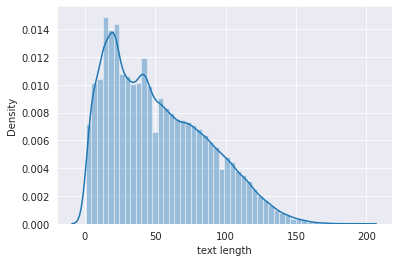

In [10]:
# Distribution of text length
##
sns.distplot(tweets['text length'])

In [11]:
# No. of unique number_of_likes and the corresponding count
##
tweets['likes'].value_counts()

0       66652
1       21976
2        9692
3        5602
4        3802
        ...  
979         1
1107        1
1512        1
3369        1
831         1
Name: likes, Length: 760, dtype: int64

## Feature Engineering

In [7]:
# Let's classify sentiment as negative, neutral or positive
##
tweets['sentiment'] = np.nan

for i in trange(len(tweets)):
    if tweets['polarity'][i] < 0:
        tweets['sentiment'][i] = 'negative'
    elif tweets['polarity'][i] == 0:
        tweets['sentiment'][i] = 'neutral'
    else:
        tweets['sentiment'][i] = 'positive'

# Preview tweets
tweets.sample(15)

100%|██████████| 128651/128651 [02:54<00:00, 738.54it/s] 


,tweet_id,text,created_at,likes,text length,polarity,sentiment
91686,1244367435282538496,Scott I deliver copy,2020-03-29 23:54:50 EAT,0,20,0.000000,neutral
31429,1418742147608629250,The federal government send extra Scott nation...,2021-07-24 04:17:41 EAT,7,79,0.045455,positive
127283,1242078844078751745,God need miracle thought bar informal,2020-03-23 13:20:47,1,37,0.000000,neutral
95574,1244361519359459329,thanks soon cant get,2020-03-29 23:31:19 EAT,0,20,0.200000,positive
82928,1244382966912032773,confirmed like,2020-03-30 00:56:33 EAT,0,14,0.400000,positive
28780,1418795337859411970,let make America I next,2021-07-24 07:49:03 EAT,0,23,0.000000,neutral
14240,1419048796684791819,versus vaccination need rediscover distinction,2021-07-25 00:36:12 EAT,0,46,0.000000,neutral
126596,1242110768176418819,pain feel sick health text call I c,2020-03-23 15:27:39,0,35,-0.714286,negative
91020,1244368540108349441,Anthony I deliver copy,2020-03-29 23:59:13 EAT,0,22,0.000000,neutral
51797,1418471363568930816,The force currently Lango subregion I privileg...,2021-07-23 10:21:41 EAT,146,103,0.000000,neutral


In [8]:
# Creating the target variable based off of the sentiment column
##
mapper = {
    'negative': -1,
    'neutral': 0,
    'positive': 1
}

tweets['target'] = tweets['sentiment'].map(mapper)

# Preview
tweets.sample(15)

,tweet_id,text,created_at,likes,text length,polarity,sentiment,target
51309,1418478309113942019,plea order complete ban sale use pandemic poor,2021-07-23 10:49:17 EAT,0,46,-0.150000,negative,-1
24793,1418873099928358922,everywhere,2021-07-24 12:58:03 EAT,2,10,0.000000,neutral,0
42981,1418571974473814018,new,2021-07-23 17:01:29 EAT,0,3,0.136364,positive,1
60897,1418336626296692736,sorry hear friend coping heat mum way glad str...,2021-07-23 01:26:17 EAT,5,73,-0.133333,negative,-1
6659,1419213469983776773,India landmark vaccine last,2021-07-25 11:30:33 EAT,1,27,0.000000,neutral,0
112577,1244334832789921796,data A fatality rate,2020-03-29 21:45:17 EAT,3,20,0.000000,neutral,0
77265,1244389851333570562,thousand people still waiting test back done k...,2020-03-30 01:23:54 EAT,6,121,-0.166667,negative,-1
114930,1244331355808251904,seriously look hand behind outbreak Christian ...,2020-03-29 21:31:28 EAT,0,56,-0.244444,negative,-1
95271,1244361917390393344,Sunday Art,2020-03-29 23:32:54 EAT,1,10,0.000000,neutral,0
127770,1242109238673096706,brain make final time,2020-03-23 15:21:34,1,21,0.000000,neutral,0


In [9]:
# Create another feature wordcount and compare its distribution with that of text length
# to see which best fits as a feature to be used in the model
##
tweets['word count'] = tweets['text'].apply(lambda text: len(text.split()))

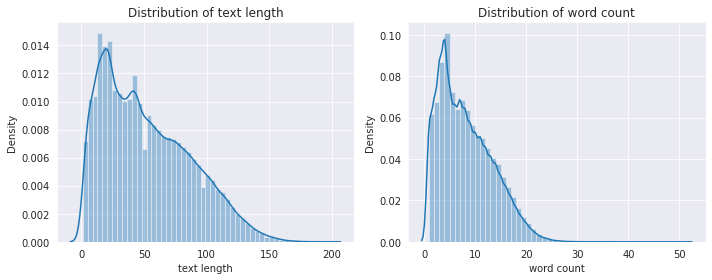

In [16]:
# Comparing the two distributions
##
fig, axes = plt.subplots(ncols=2, figsize=(10,4))

sns.distplot(tweets['text length'], ax=axes[0])
axes[0].set_title("Distribution of text length")

sns.distplot(tweets['word count'], ax=axes[1])
axes[1].set_title("Distribution of word count")

plt.tight_layout()

Seems that the two distributions have an identical pattern  
We'll use both features in the model building phase

In [13]:
tweets.head()

,tweet_id,text,created_at,likes,text length,polarity,sentiment,target,word count
0,1419307341560745985,face bound border two The covid said hidden,2021-07-25 17:43:34 EAT,0,43,-0.166667,negative,-1,8
1,1419307340680114179,I seeing looking like second global going,2021-07-25 17:43:34 EAT,0,41,0.000000,neutral,0,7
2,1419307335982346240,sentence people intensive care,2021-07-25 17:43:33 EAT,0,30,0.000000,neutral,0,4
3,1419307331599339521,contagious delta variant surging across nation...,2021-07-25 17:43:31 EAT,0,98,0.000000,neutral,0,12
4,1419307315220475908,sentence people intensive care,2021-07-25 17:43:28 EAT,0,30,0.000000,neutral,0,4


## Model Building

In [10]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [11]:
# BOW (bag of words)
##
cv = CountVectorizer(analyzer='word', stop_words=stop)

cv.fit(tweets['text'])

CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [25]:
# Preview vocabulary and the number of vocab words
##
print(len(cv.vocabulary_))

18915


In [26]:
list(cv.vocabulary_)[:10]

['face',
 'bound',
 'border',
 'two',
 'covid',
 'said',
 'hidden',
 'seeing',
 'looking',
 'like']

In [27]:
# Example transforming a single text
##
print(cv.transform([tweets['text'][0]]))

  (0, 1889)	1
  (0, 1926)	1
  (0, 3673)	1
  (0, 5910)	1
  (0, 7589)	1
  (0, 14324)	1
  (0, 17355)	1


In [28]:
# Example getting the feature name by index
##
cv.get_feature_names()[7523]

'helpless'

In [12]:
# Transforming the whole BOW to a sparse matrix
##
bow_text = cv.transform(tweets['text'])

In [30]:
# Non-zero occurrences
##
bow_text.nnz

935370

In [13]:
# tfidf weighting
##
tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(bow_text)

TfidfTransformer()

In [32]:
# Example transforming a single bow
##
print(tfidf_transformer.transform(cv.transform([tweets['text'][0]])))

  (0, 17355)	0.36382217854753895
  (0, 14324)	0.33536544967797327
  (0, 7589)	0.4312292397319281
  (0, 5910)	0.3748466201388867
  (0, 3673)	0.2626363014015341
  (0, 1926)	0.4334212820075949
  (0, 1889)	0.4145635743995186


In [33]:
# Example getting idf weight of a word
##
tfidf_transformer.idf_[cv.vocabulary_['good']]

5.147106787035735

In [14]:
# Transforming the whole sparse matrix
##
tfidf_text = tfidf_transformer.transform(bow_text)

Adding 'text length' and 'word count' as features to the model  
We'll stack the features to the sparse matrix horizontally

In [31]:
"""# Transforming the two columns into sparse matrices
##
txt_length = coo_matrix(tweets['text length']).reshape(1182,1)
wrd_cnt = coo_matrix(tweets['word count']).reshape(1182,1)

features = hstack([tfidf_text, txt_length, wrd_cnt])

# Preview difference in shapes
print("Shape of text column sparse matrix: ", tfidf_text.shape)
print("Shape of concatenated features sparse matrix: ", features.shape)"""

'# Transforming the two columns into sparse matrices\n##\ntxt_length = coo_matrix(tweets[\'text length\']).reshape(1182,1)\nwrd_cnt = coo_matrix(tweets[\'word count\']).reshape(1182,1)\n\nfeatures = hstack([tfidf_text, txt_length, wrd_cnt])\n\n# Preview difference in shapes\nprint("Shape of text column sparse matrix: ", tfidf_text.shape)\nprint("Shape of concatenated features sparse matrix: ", features.shape)'

In [15]:
features = tfidf_text

## Comparing different classification models:  
- Logistic Regression
- Linear SVC (svm)
- SGD Classifier
- Random Forest Classifier
- Xgboost Classifier
- LGBM Classifier

In [16]:
# Splitting data into train and test splits
##
X_train, X_test, y_train, y_test = train_test_split(features, tweets['target'], test_size=0.2)

In [17]:
# Initialize models
##
lr = LogisticRegression(C=2.0, class_weight=None, dual=False, max_iter=100)

svc = LinearSVC(C=2.0, class_weight=None, dual=False, max_iter=100)

sgd = SGDClassifier()

rfc = RandomForestClassifier(bootstrap=False, class_weight=None, 
                             criterion='entropy', min_samples_split=6, n_estimators=160, warm_start=False)

xgb = XGBClassifier(objective='multi:softmax', num_class=3)

lgbm = LGBMClassifier(objective='multiclass')

In [ ]:
# Train models
##
lr.fit(X_train, y_train)

svc.fit(X_train, y_train)

sgd.fit(X_train, y_train)

rfc.fit(X_train, y_train)

xgb.fit(X_train,y_train)

lgbm.fit(X_train, y_train)

In [27]:
# Make predictions
##
lr_pred = lr.predict(X_test)

svc_pred = svc.predict(X_test)

sgd_pred = sgd.predict(X_test)

rfc_pred = rfc.predict(X_test)

xgb_pred = xgb.predict(X_test)

lgbm_pred = lgbm.predict(X_test)

In [28]:
# Evaluate models
##
print("Logistic Regression \n----------------------------------")
print(confusion_matrix(y_test, lr_pred))
print(classification_report(y_test, lr_pred))

print("Linear SVC \n---------------------------------")
print(confusion_matrix(y_test, svc_pred))
print(classification_report(y_test, svc_pred))

print("SGD \n---------------------------------")
print(confusion_matrix(y_test, sgd_pred))
print(classification_report(y_test, sgd_pred))

print("Random Forest Classifier \n----------------------------------")
print(confusion_matrix(y_test, rfc_pred))
print(classification_report(y_test, rfc_pred))

print("Xgboost Classifier \n----------------------------------")
print(confusion_matrix(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred))

print("LGBM \n---------------------------------")
print(confusion_matrix(y_test, lgbm_pred))
print(classification_report(y_test, lgbm_pred))

Logistic Regression 
----------------------------------
[[ 4211   307   297]
 [   40 11296    75]
 [  183   318  9004]]
              precision    recall  f1-score   support

          -1       0.95      0.87      0.91      4815
           0       0.95      0.99      0.97     11411
           1       0.96      0.95      0.95      9505

    accuracy                           0.95     25731
   macro avg       0.95      0.94      0.94     25731
weighted avg       0.95      0.95      0.95     25731

Linear SVC 
---------------------------------
[[ 4489   109   217]
 [   53 11289    69]
 [  154   109  9242]]
              precision    recall  f1-score   support

          -1       0.96      0.93      0.94      4815
           0       0.98      0.99      0.99     11411
           1       0.97      0.97      0.97      9505

    accuracy                           0.97     25731
   macro avg       0.97      0.96      0.97     25731
weighted avg       0.97      0.97      0.97     25731

SGD 
---

In [38]:
cross_val_score(svc, features, tweets['target'], cv=5)

array([0.97100773, 0.96972406, 0.97372717, 0.96976292, 0.96902449])

In [ ]:
# Making sure that the models are not overfitting using cross val score metric with 5 folds
##
print("Logistic Regression \n------------------------- \nscore= ", cross_val_score(lr, features, tweets['target'], cv=5).mean())
print("\nLinear SVC \n------------------------- \nscore=", cross_val_score(svc, features, tweets['target'], cv=5).mean())
print("\nRandom Forest Classifier \n------------------------- \nscore=", cross_val_score(rfc, features, tweets['target'], cv=5).mean())
print("\nXgboost Classifier \n------------------------- \nscore=", cross_val_score(xgb, features, tweets['target'], cv=5).mean())

Logistic Regression 
------------------------- 
score=  0.9492269631769622

Linear SVC 
------------------------- 
score= 0.9706492731618044


In [38]:
# linear SVC performed best
# That's a good score having in mind that the model is attempting to predict between three category classes

In [29]:
# saving model
from sklearn.pipeline import Pipeline
import pickle

# retrain
pipe = Pipeline([('vectorizer', TfidfVectorizer()), ('classifier', LinearSVC(C=2.0, class_weight=None, dual=False, max_iter=100))])
pipe.fit(tweets.text, tweets.target)
pickle.dump(pipe, open('saved_model.pkl', 'wb'))

In [30]:
# load model
model = pickle.load(open('saved_model.pkl', 'rb'))

In [31]:
model.predict(["I don't know"])

array([0])

In [32]:
np.int(pipe.predict(["I love people."]))

1